# Integral Analysis of GRB 230307A -- CARMA Modeling

Let's start with the INTEGRAL data, which is not highly affected by dead time and saturation.

We need to implement a CARMA model

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

import numpy as np
import scipy.io

import jax
# Important to enable 64-bit precision
jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import random
import tensorflow_probability.substrates.jax as tfp

from tinygp import GaussianProcess, kernels
from jaxns.utils import resample

import stingray
from stingray import Lightcurve, Powerspectrum
from stingray.modeling.gpmodeling import get_kernel, get_mean
from stingray.modeling.gpmodeling import get_prior, get_log_likelihood, get_gp_params

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

# abbreviations for tensorflow distributions + bijectors
tfpd = tfp.distributions
tfpb = tfp.bijectors


INFO[2023-10-02 18:37:45,104]: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
I0000 00:00:1696264665.104184       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
INFO[2023-10-02 18:37:45,105]: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-10-02 18:37:45,109]: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/danielahuppenkothen/work/sw/miniconda3/envs/grbsearch/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)
/Users/danielahuppenkothen/work/repositories/stingraysoftware/stingray/stingray/utils.py:35: UserWarning: pyfftw not installed.

In [2]:
datadir = "/Users/danielahuppenkothen/work/repositories/grb230307a_qposearch/data/"

In [3]:
data = scipy.io.readsav(datadir+"acs_lc_bary.sav")

In [4]:
data

{'barytime': array([-6.87185967, -6.82185948, -6.77185976, ..., 98.02814186,
        98.07813728, 98.12814033], dtype='>f8'),
 'counts': array([4502., 4570., 4576., ..., 4516., 4444., 4514.], dtype='>f4')}

In [5]:
barytime = np.array(data["barytime"], dtype=float)
counts = np.array(data["counts"], dtype=float)

In [6]:
mean_bkg = np.mean(counts[-100:])

In [7]:
lc = Lightcurve(barytime, counts-mean_bkg)
minind = lc.time.searchsorted(0.0)
maxind = lc.time.searchsorted(60.0)
lc = lc.truncate(start=minind, stop=maxind, method="index")
ps = Powerspectrum(lc, norm="leahy")

INFO[2023-10-02 18:37:46,611]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2023-10-02 18:37:46,612]: Checking if light curve is sorted.
INFO[2023-10-02 18:37:46,613]: Computing the bin time ``dt``. This can take time. If you know the bin time, please specify it at light curve creation


<IPython.core.display.Javascript object>


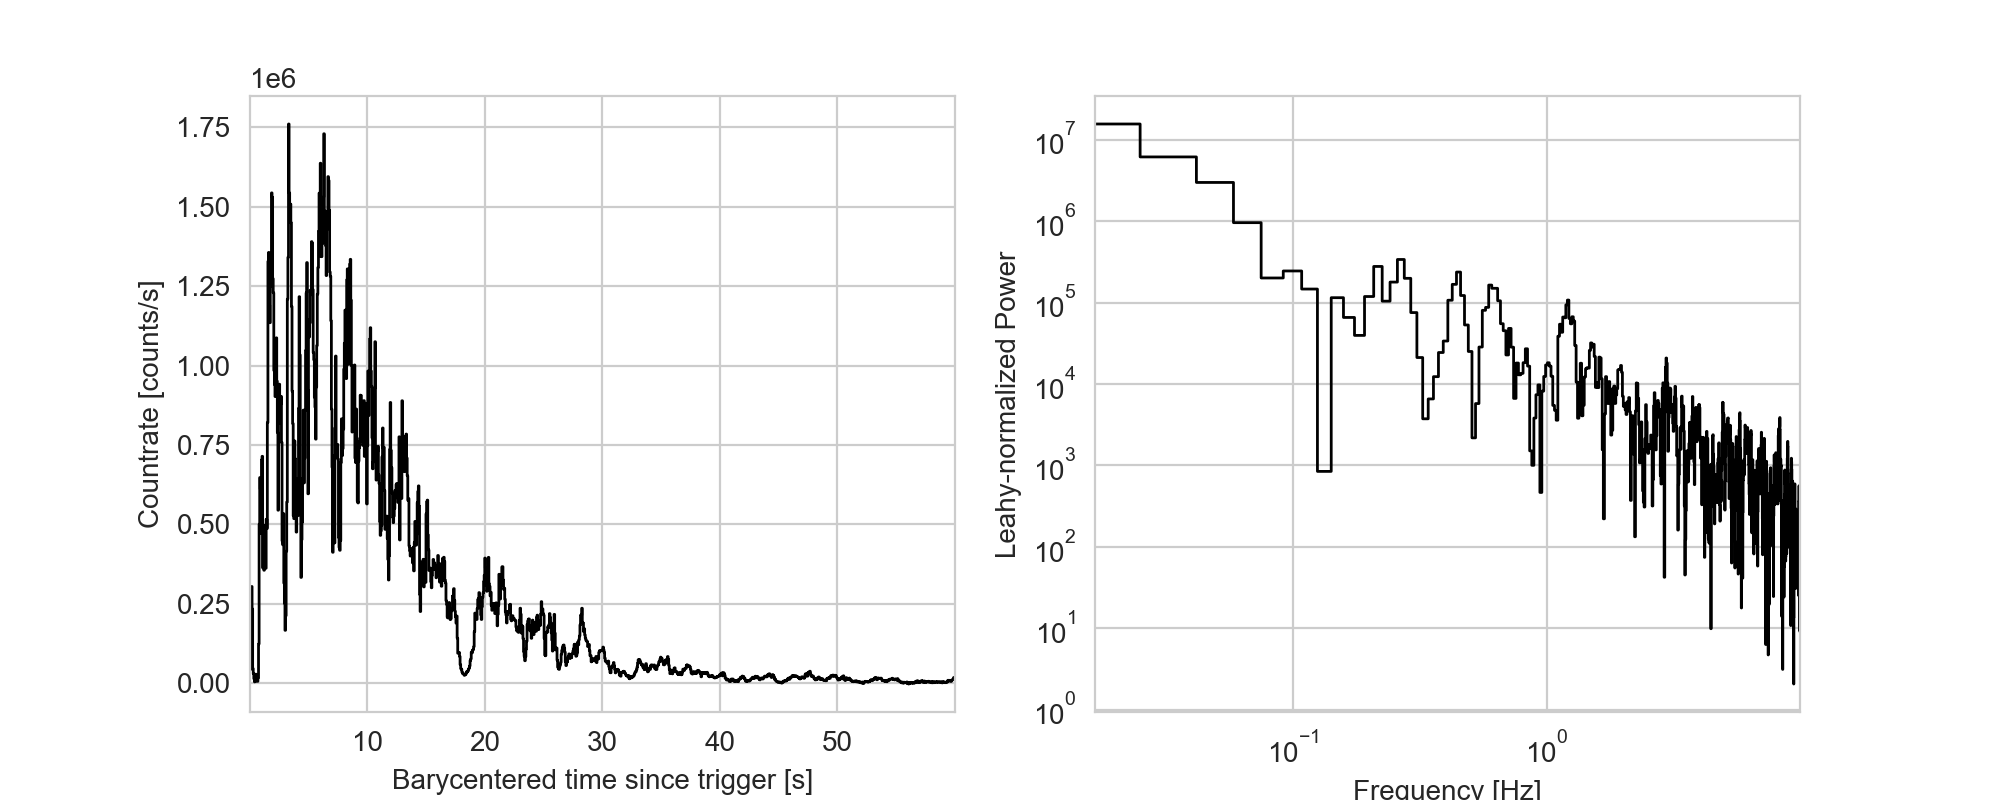

Text(0, 0.5, 'Leahy-normalized Power')

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.plot(lc.time, lc.countrate, lw=1, color="black", ds="steps-mid")
ax1.set_xlim(lc.time[0], lc.time[-1])
ax1.set_xlabel("Barycentered time since trigger [s]")
ax1.set_ylabel("Countrate [counts/s]")

ax2.loglog(ps.freq, ps.power, ds="steps-mid", lw=1, color="black")
ax2.set_xlim(ps.freq[0], ps.freq[-1])
ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel("Leahy-normalized Power")

## CARMA Model

Let's build a CARMA model in TinyGP to do this modeling:

In [9]:
from tinygp.kernels.quasisep import CARMA
from tinygp import GaussianProcess

In [10]:
from functools import partial

<IPython.core.display.Javascript object>


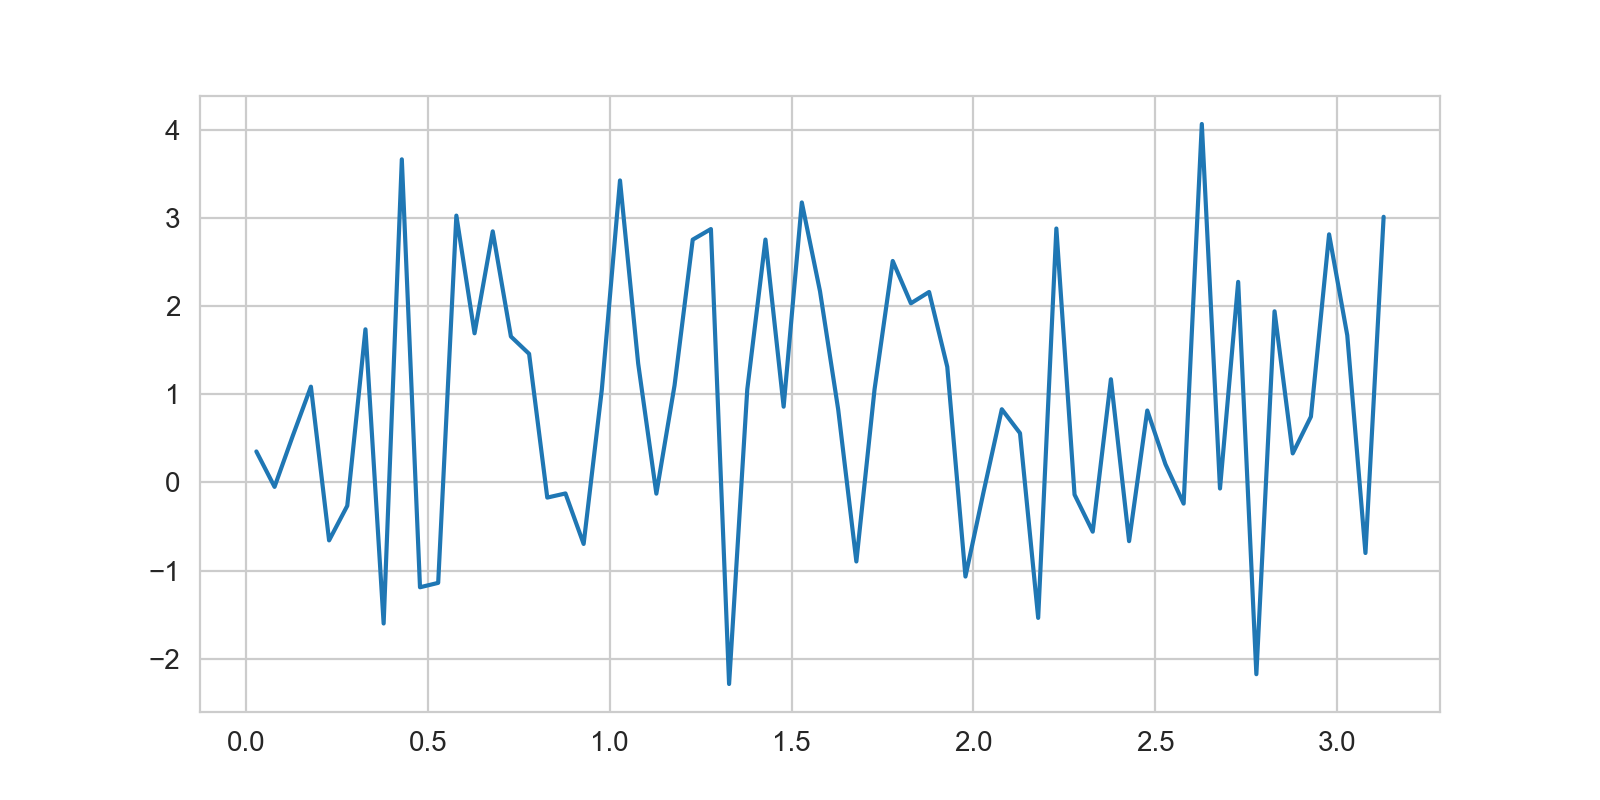

In [11]:
alpha = [1.5, 0.1]
beta = [1.3]
sigma = 0.1
kernel = CARMA.init(alpha=alpha, beta=beta, sigma=sigma)
gp = GaussianProcess(kernel, lc.time, mean_value=np.ones_like(lc.time), diag=2)

key = random.PRNGKey(np.random.randint(0, 1e10))
sample = gp.sample(key)

fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.plot(lc.time, sample)

In [12]:
@partial(jax.jit, static_argnames=['p', "q"])
def set_carma_process(*args, p=2, q=1):
    alpha = args[0]
    beta = args[1]
    acarma = args[2]
    print(alpha)
    print(beta)
    print(acarma)
    
    kernel = kernels.quasisep.CARMA.init(alpha=alpha, beta=beta, sigma=acarma)
    gp = GaussianProcess(kernel, lc.time, mean_value = jnp.ones_like(lc.time), diag=2)
    key = random.PRNGKey(np.random.randint(0, 1e10))
    sample = gp.sample(key)

    return sample


Traced<ShapedArray(float64[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>
Traced<ShapedArray(float64[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>
Traced<ShapedArray(float64[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>


<IPython.core.display.Javascript object>


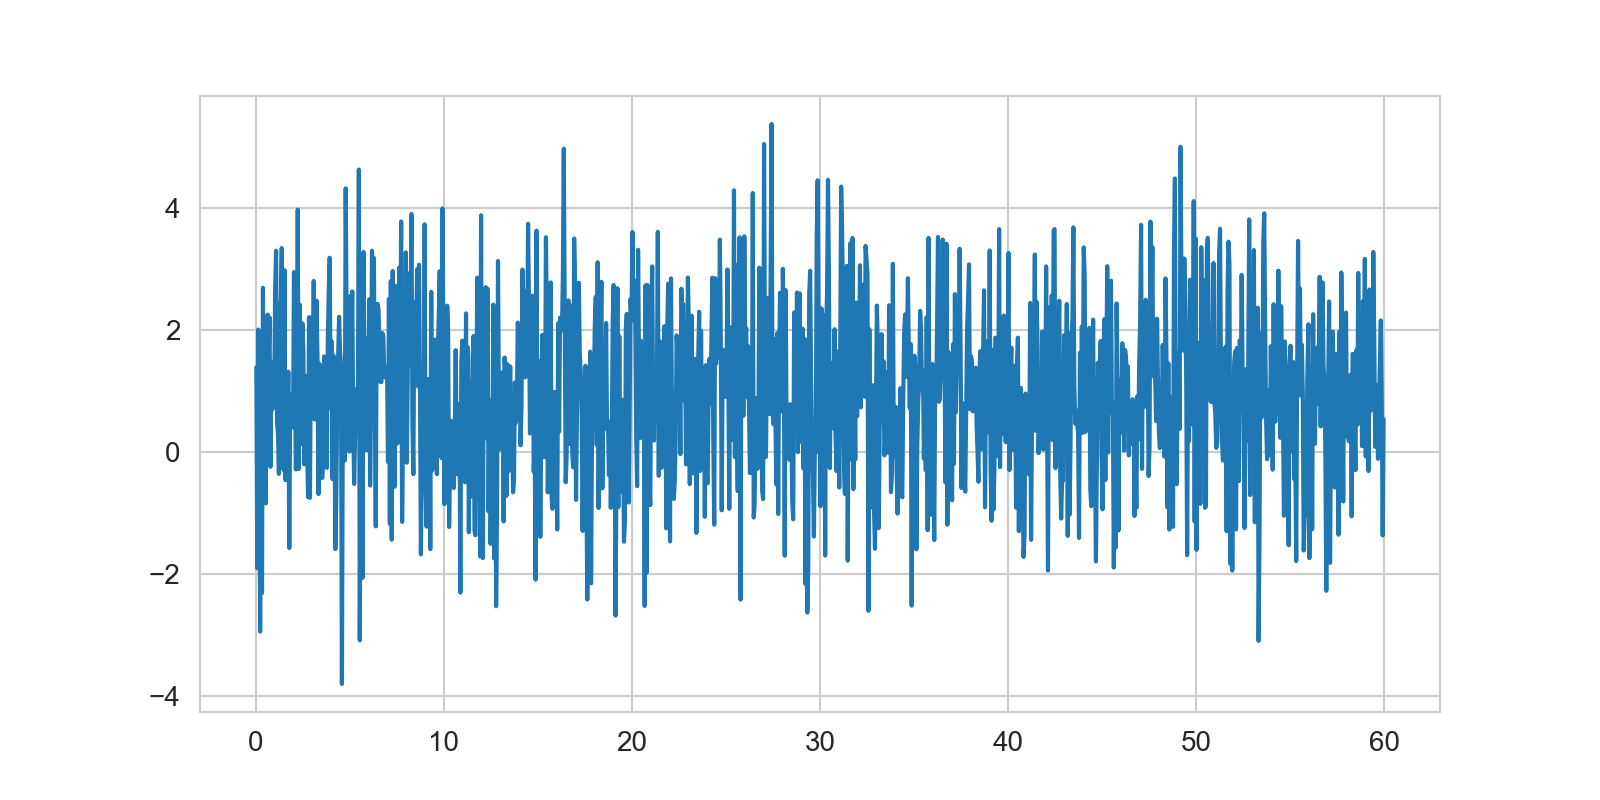

[ 1.38711104 -1.90640066  2.00515097 ...  0.79652655 -1.36792829
  0.53702184]


In [13]:
alpha = [1.5, 0.1]
beta = [1.3]
sigma = 0.1

#sample = set_carma_process(np.log(1.5), np.log(0.1), np.log(1.3), 0.1)
sample = set_carma_process(1.5, 0.1, 0.1)
fig, ax = plt.subplots(1, 1, figsize=(8,4))
print(sample)
ax.plot(lc.time, sample)

In [14]:
lc.counts_err

array([0., 0., 0., ..., 0., 0., 0.])

## Gaussian Process Analysis on the Full Light Curve

Let's do the GP Analysis on the full light curve. We start by comparing a Damped Random Walk with a QPO model:

In [15]:
kernel_type = "CARMA"
mean_type = "skew_gaussian"
params_list = get_gp_params(kernel_type= kernel_type, mean_type = mean_type)

print("parameters list", params_list)

parameters list ['log_alpha', 'log_beta', 'log_acarma', 'log_A', 't0', 'log_sig1', 'log_sig2']


In [16]:
times = lc.time
counts = lc.counts

In [17]:
counts.dtype

dtype('float64')

In [19]:
total_time = times[-1] - times[0]
f = 1/(times[1]- times[0])
span = jnp.max(counts) - jnp.min(counts)

# The prior dictionary, with suitable tfpd prior distributions
prior_dict = {
    "t0": tfpd.Uniform(low = 0.0, high = 20.0),
    "log_A": tfpd.Uniform(5, 15),
    "log_sig1": tfpd.Uniform(-1, 3.5),
    "log_sig2": tfpd.Uniform(1, 4.0),
    #"log_freq": tfpd.Uniform(0.3, 5.0),
    #"log_aqpo": tfpd.Uniform(2, 20),
    #"log_cqpo": tfpd.Uniform(-10, 10),
    "log_alpha": tfpd.Uniform(-10, 10),
    "log_beta": tfpd.Uniform(-10, 10),
    "log_acarma" : tfpd.Uniform(2, 20)
#    "log_arn": tfpd.Uniform(2, 20),
#    "log_crn": tfpd.Uniform(-10, 10)
}

params_list2 = ['log_alpha', 'log_beta', 'log_acarma', "log_A", "t0", "log_sig1", "log_sig2"]

prior_model = get_prior(params_list2, prior_dict, p=2, q=1)

log_likelihood_model = get_log_likelihood(params_list2, kernel_type= kernel_type, mean_type = mean_type, 
                                          times = times, counts = counts, p=2, q=1)

In [20]:
log_likelihood_model(1, 2, 3, 4, 5,1, 23, 8)

Array(-inf, dtype=float64)

In [ ]:
from stingray.modeling.gpmodeling import GPResult

gpresult_rn = GPResult(lc = lc)
gpresult_rn.sample(prior_model = prior_model, likelihood_model = log_likelihood_model,
               max_samples=1e6)

INFO[2023-10-02 18:37:58,649]: Sanity check...
INFO[2023-10-02 18:37:58,983]: Sanity check passed


In [ ]:
print("log Evidence: ", gpresult_rn.get_evidence())

In [ ]:
plot = gpresult_rn.posterior_plot("log_A")
plt.show()

In [ ]:
gpresult_rn.print_summary()

In [ ]:
gpresult_rn.exact_ns.plot_diagnostics(gpresult_rn.results)

In [ ]:
gpresult_rn.plot_cornerplot()

Let's write a function to plot the posterior predictive distribution (sort of):

In [ ]:
def plot_posterior_predictive(lc, gpresult, kernel_type, mean_type, nmean=50, ngrid=1000, ax=None, rkey=None):
    """
    Plot the posterior predictive distribution.
    Will plot the maximum posterior for the Gaussian Process, and 
    `nsamples` random draws from the mean function.
    
    Parameters
    ----------
    lc : stingray.Lightcurve object
        The light curve with the time series data 
        being modelled
    
    nsresults : jaxns.Results object
        The results from the sampling
        
    kernel_type : str
        The kernel type used in the modeling
        
    mean_type : str
        The type of the mean function used
    
    nmean: int, default 50
        The number of samples to use for drawing the 
        posterior
        
    ngrid: int, default 1000
        The number of points in the linear grid to 
        use for plotting the Gaussian Process
    
    ax : matplotlib.Axes object, default None
        A matplotlib.Axes object to plot into. If none is 
        given, a new Figure object will be created
        
    rkey : jax.randomPRNGKey object
        A random key for setting the sampling. If None,
        set to random.PRNGKey(1234)
    
    Returns
    -------
    ax : matplotlib.Axes object
        The matplotlib.axes object that the plot is 
        drawn in
    """
    if rkey is None:
        rkey = random.PRNGKey(1234)

    log_p = gpresult.results.log_dp_mean #log-prob
    nsamples = gpresult.results.total_num_samples # number of samples

    # array for resampled samples
    samples_resampled = {}

    # go through samples, resample with weights to get 
    # a weighted posterior sample
    for name in gpresult.results.samples.keys():
        samples = gpresult.results.samples[name]

        weights = jnp.where(jnp.isfinite(samples), jnp.exp(log_p), 0.0)
        log_weights = jnp.where(jnp.isfinite(samples), log_p, -jnp.inf)
        sr = resample(
            rkey, samples, log_weights, S=max(10, int(gpresult.results.ESS)), replace=True
    )
        samples_resampled[name] = sr

    print("Resampling done, calculating maximum posterior model ...")
    # split into samples belonging to the kernel, and samples 
    # belonging to the mean function
    kernel_params = stingray.modeling.gpmodeling._get_kernel_params(kernel_type)
    mean_params = stingray.modeling.gpmodeling._get_mean_params(mean_type)

    mean_samples = dict((k, samples_resampled[k]) for k in mean_params)

    maxpost_log = gpresult.get_max_posterior_parameters()

    sk_maxpost_log = dict((k, maxpost_log[k]) for k in kernel_params)
    sm_maxpost_log = dict((k, maxpost_log[k]) for k in mean_params)

    sk_maxpost, sm_maxpost = {}, {}
    for params in kernel_params:
        if params[0:4] == "log_":
            sk_maxpost[params[4:]] = jnp.exp(sk_maxpost_log[params])
        else:
            sk_maxpost[params] = sk_maxpost_log[params]

    for params in mean_params:
        if params[0:4] == "log_":
            sm_maxpost[params[4:]] = jnp.exp(sm_maxpost_log[params])
        else:
            sm_maxpost[params] = sm_maxpost_log[params]
            
    print(mean_type)
    kernel = get_kernel(kernel_type=kernel_type, kernel_params=sk_maxpost)
    mean = get_mean(mean_type=mean_type, mean_params=sm_maxpost)
    
    gp = GaussianProcess(kernel, lc.time, mean_value=mean(lc.time))
    tgrid = np.linspace(lc.time[0], lc.time[-1], ngrid)
    _, cond = gp.condition(lc.counts, tgrid)

    mu = cond.loc + mean(tgrid)
    std = np.sqrt(cond.variance)

    print("GP calculated, plotting GP and data ...")
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8,4))

    ax.errorbar(lc.time, lc.counts, yerr=np.sqrt(lc.counts), 
                fmt="o", markersize=2, color="black",
                label="Observations")
    ax.plot(tgrid, mu, color="C0", label="Gaussian Process Maximum Posterior")
    ax.fill_between(tgrid, mu + std, mu - std, color="C0", alpha=0.3)

    idx_all = np.random.choice(np.arange(0,int(gpresult.results.ESS), 1.0, dtype=int), 
                               size=nmean,
                               replace=False)
    print("calculating and plotting mean functions ...")
    for i, idx in enumerate(idx_all):
        #sk_log = dict((k, kernel_samples[k][idx]) for k in kernel_params)
        sm_log = dict((k, mean_samples[k][idx]) for k in mean_params)
        sm = {}
        for params in mean_params:
            if params[0:4] == "log_":
                sm[params[4:]] = jnp.exp(sm_log[params])
            else:
                sm[params] = sm_log[params]

        mean = get_mean(mean_type=mean_type, mean_params=sm)
        mean_vals = mean(times)
        
        # legend only for the first line being drawn
        if i == 0:
            ax.plot(times, mean_vals, color="orange", 
                    alpha=0.1, label="Mean function posterior draws")  
        else:
            ax.plot(times, mean_vals, color="orange", alpha=0.1)

    # update legend opacity
    leg = ax.legend()
    for lh in leg.legendHandles: 
        lh.set_alpha(1)

    return ax

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax = plot_posterior_predictive(lc, gpresult_rn, kernel_type, mean_type, 
                               nmean=20, ngrid=3000, ax=ax, rkey=None)

ax.set_xlim(lc.time[0], lc.time[-1])
ax.set_xlabel("Barycentered time since trigger [s]")
ax.set_ylabel("Counts per bin")

## Red Noise + QPO

let's do a model with both red noise and a QPO:

In [ ]:
kernel_type = "QPO_plus_RN"
mean_type = "skew_gaussian"
params_list = get_gp_params(kernel_type= kernel_type, mean_type = mean_type)

print("parameters list", params_list)

In [ ]:
total_time = times[-1] - times[0]
f = 1/(times[1]- times[0])
span = jnp.max(counts) - jnp.min(counts)

# The prior dictionary, with suitable tfpd prior distributions
prior_dict = {
    "t0": tfpd.Uniform(low = 0.0, high = 20.0),
    "log_A": tfpd.Uniform(5, 15),
    "log_sig1": tfpd.Uniform(-1, 3.5),
    "log_sig2": tfpd.Uniform(1, 4.0),
    "log_freq": tfpd.Uniform(np.log(1.0), np.log(3.0)),
    "log_aqpo": tfpd.Uniform(2, 20),
    "log_cqpo": tfpd.Uniform(-10, 10),
    "log_arn": tfpd.Uniform(2, 20),
    "log_crn": tfpd.Uniform(-10, 10)
}

#params_list2 = ["log_arn", "log_crn", "log_A", "t0", "log_sig1", "log_sig2"]

prior_model = get_prior(params_list, prior_dict)

log_likelihood_model = get_log_likelihood(params_list, kernel_type= kernel_type, mean_type = mean_type, 
                                          times = times, counts = counts)

In [ ]:
from stingray.modeling.gpmodeling import GPResult

gpresult_qporn = GPResult(lc = lc)
gpresult_qporn.sample(prior_model = prior_model, likelihood_model = log_likelihood_model,
               max_samples=1e6)

In [ ]:
print("log Evidence: ", gpresult_rn.get_evidence())

In [ ]:
print("log Evidence: ", gpresult_qporn.get_evidence())

In [ ]:
gpresult_qporn.get_evidence() - gpresult_rn.get_evidence()

In [ ]:
plt.figure()
plot = gpresult_rn.posterior_plot("log_A")
plt.show()

In [ ]:
gpresult_qporn.print_summary()

In [ ]:
gpresult_qporn.exact_ns.plot_diagnostics(gpresult_qporn.results)

In [ ]:
gpresult_qporn.plot_cornerplot()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax = plot_posterior_predictive(lc, gpresult_qporn, kernel_type, mean_type, 
                               nmean=20, ngrid=3000, ax=ax, rkey=None)

ax.set_xlim(lc.time[0], lc.time[-1])
ax.set_xlabel("Barycentered time since trigger [s]")
ax.set_ylabel("Counts per bin")

Okay, that looks better. Phew. Let's plot the QPO frequency:

In [ ]:
plt.figure()
gpresult_qporn.posterior_plot("log_freq")

In [ ]:
samples = gpresult_qporn.results.samples["log_freq"]
rkey = random.PRNGKey(1234)

log_p = gpresult_qporn.results.log_dp_mean #log-prob
nsamples = gpresult_qporn.results.total_num_samples # number of samples

weights = jnp.where(jnp.isfinite(samples), jnp.exp(log_p), 0.0)
log_weights = jnp.where(jnp.isfinite(samples), log_p, -jnp.inf)
freq_resampled = resample(
    rkey, samples, log_weights, S=max(10, int(gpresult_qporn.results.ESS)), replace=True
)

In [ ]:
freq = np.exp(freq_resampled)
period = 1.0/freq

In [ ]:
period

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

ax1.hist(freq, bins=100, histtype="stepfilled", alpha=0.5)
ax1.set_xlabel("Frequency [Hz]")

ax2.hist(period, bins=100, histtype="stepfilled", alpha=0.5)
ax2.set_xlabel("Period [s]")

In [ ]:
np.log10(np.exp(gpresult_qporn.get_evidence() - gpresult_rn.get_evidence()))